In [59]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr
from sklearn.svm import SVR
import re
import spacy
import spacy.lang.ro.stop_words as stop_words
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

tqdm.pandas()

In [22]:
train_dataset = pd.read_csv("./datasets/train.csv")
validation_dataset = pd.read_csv("./datasets/val.csv")
test_dataset = pd.read_csv("./datasets/test.csv")

In [23]:
def normalize_to_range(y, min_val=-1, max_val=1):
    y_min = y.min()
    y_max = y.max()
    return (y - y_min) / (y_max - y_min) * (max_val - min_val) + min_val

# Assuming y and y_validation are already defined
train_dataset['score'] = normalize_to_range(train_dataset['score'], -1, 1)
validation_dataset['score'] = normalize_to_range(validation_dataset['score'], -1, 1)

In [24]:
train_dataset

,id,text,score
0,196112,A sandwich and french bread sit on a cutting b...,-0.777778
1,514558,A baseball player is standing on the field whi...,-0.333333
2,54244,A casserole served at a restaurant in a brown ...,0.555556
3,9420,OLD BLACK AND WHITE PHOTO OF AN ALL BOYS SCHOOL,0.777778
4,531512,A woman is milking a cow in the animal stable.,-0.166667
...,...,...,...
7995,419064,A fire hydrant that is silver with a red top a...,0.466667
7996,344521,"A plate is filled with broccoli, apples, straw...",0.333333
7997,33652,A homemade pizza is shown with cheese and chic...,0.629630
7998,108123,The baseball player hits the ball with a stron...,-0.416667


# Score distribution

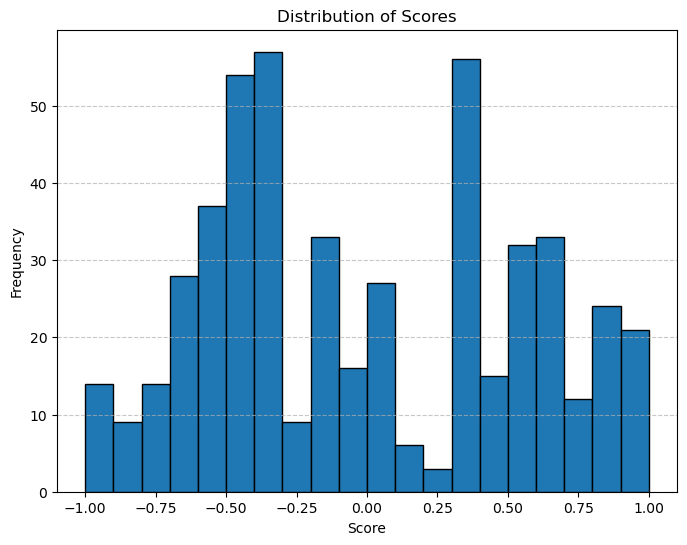

In [25]:
plt.figure(figsize=(8, 6))
plt.hist(validation_dataset['score'], bins=20, edgecolor='black', alpha=1)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [26]:
# nlp = spacy.load("en_core_web_sm")

# Compile the regular expression pattern
pattern = re.compile(r"[^a-z ]")

# Convert stop words list to a set for faster lookup
sw_set = set(stop_words.STOP_WORDS)
sw_lower = set(word.lower() for word in stop_words.STOP_WORDS)

def text_preparetion(sentence):
    # 1. Lowercase everything
    sentence = sentence.lower()

    # 2. Remove all symbols other than a-z@#.
    sentence = re.sub(pattern, " ", sentence)

    # Tokenize the preprocessed sentence
    # tokenization = nlp(sentence)
    # 
    # # 4. Remove stopwords and empty tokens, and perform stemming
    # list_text_preprocessed = [
    #     token.text for token in tokenization if 
    #     not token.is_stop and 
    #     token.pos_ != "SPACE"
    # ]
    # for token in tokenization:
    #     print(
    #         f"Text: {token.text}, Lemma: {token.lemma_}, POS Tag: {token.pos_}, Dependency: {token.dep_}, "
    #         f"Stop Word?: {token.is_stop}, Entity Type: {token.ent_type_}"
    #     )
    # Join the stemmed tokens back into a sentence
    # processed_text = ' '.join(list_text_preprocessed)

    return sentence

sentence1 = "A World War II-era bomber flying out of formation"
text_preparetion(sentence1)

'a world war ii era bomber flying out of formation'

In [27]:
train_dataset['preprocessed_text'] = train_dataset['text'].progress_apply(text_preparetion)
validation_dataset['preprocessed_text'] = validation_dataset['text'].progress_apply(text_preparetion)
test_dataset['preprocessed_text'] = test_dataset['text'].progress_apply(text_preparetion)

100%|██████████| 500/500 [00:00<00:00, 495897.85it/s]


In [77]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(train_dataset["text"].values)
# X = X.toarray()

X_validation = vectorizer.transform(validation_dataset["text"].values)
# X_validation = X_validation.toarray()

y = train_dataset["score"].values
y_validation = validation_dataset["score"].values

# Sentences distribution

In [82]:

# Assuming `tfidf_matrix` is your TF-IDF matrix
# PCA
pca = PCA(n_components=3)
reduced_pca = pca.fit_transform(X_validation)

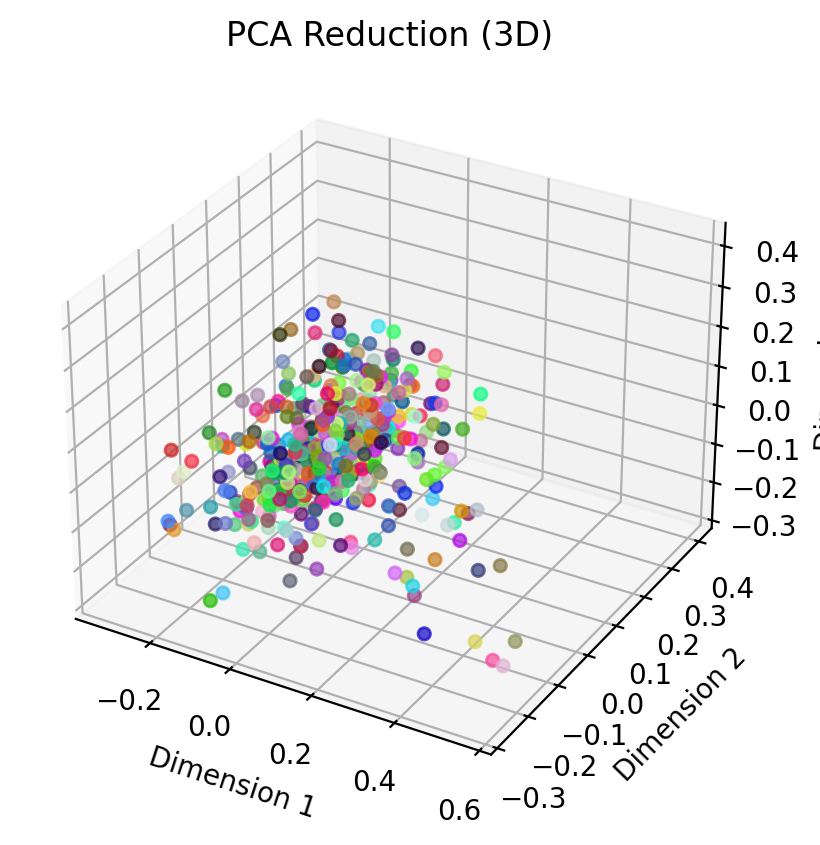

In [83]:
num_sentences = X_validation.shape[0]
colors = np.random.rand(num_sentences, 3)

def plot_3d(data, title, color='blue'):
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], alpha=0.7, c=colors)
    ax.set_title(title)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    plt.show()

# Plot PCA
plot_3d(reduced_pca, "PCA Reduction (3D)")

# SVR

In [29]:
# Define ranges for hyperparameters C and epsilon
C_values = [0.1, 1, 10, 100]
epsilon_values = [0.01, 0.1, 1]

# Perform hyperparameter tuning
for C in C_values:
    for epsilon in epsilon_values:
        # Initialize and train the model
        model = SVR(kernel="poly", C=C, epsilon=epsilon)
        model.fit(X, y)
        
        # Predict and calculate metrics
        y_pred = model.predict(X_validation)
        mse = mean_squared_error(y_validation, y_pred)
        spearman_corr, _ = spearmanr(y_validation, y_pred)

        print({
            "C": C,
            "Epsilon": epsilon,
            "MSE": mse,
            "Spearman Correlation": spearman_corr
        })

SVR(C=0.01, epsilon=0.01, kernel='sigmoid')

# Test

In [32]:
test_dataset["score"] = model.predict(vectorizer.transform(test_dataset["preprocessed_text"].values))

In [33]:
test_dataset.drop(["text"], axis=1, inplace=True)

In [34]:
test_dataset.to_csv("./datasets/submission.csv", index=False)